# Лабораторная работа №2

In [6]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант для задания №3:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [8]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений CIFAR100
### Загрузка и распаковка набора данных CIFAR100

In [10]:
import os
import shutil
import urllib
from pathlib import Path

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
model_path = Path("data")

model_path.mkdir(exist_ok=True)

file_path = model_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=model_path)
    file_path.unlink()  # Remove archive after extracting it.

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### Чтение тренировочной и тестовой выборки

In [12]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [13]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [14]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [15]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


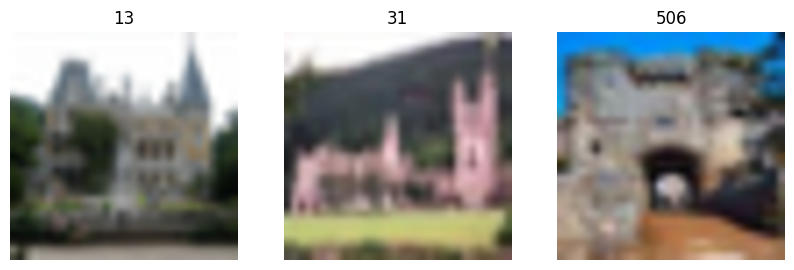

class_id = 70:


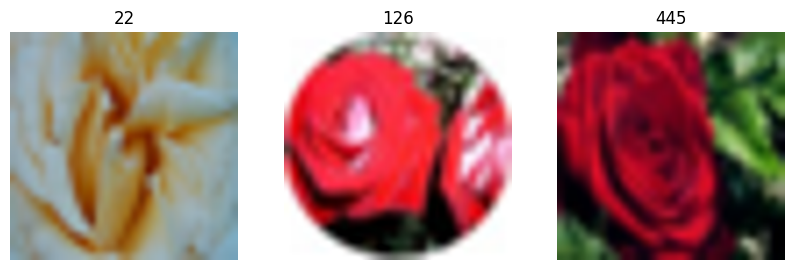

class_id = 35:


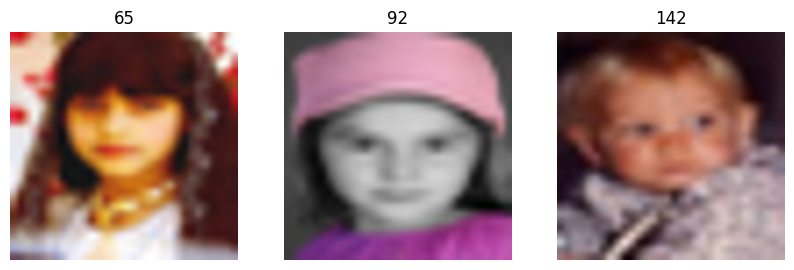

In [16]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Pytorch DataLoader'a

In [17]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = TensorDataset(tensor_x, tensor_y)  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset, batch_size=batch_size, shuffle=True
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [18]:
HIDDEN_SIZE = 32


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)


class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, hidden_size, 5, stride=4, padding=2),
            nn.ReLU(),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(hidden_size, hidden_size * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),  # nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
# NEW
model.to(device)
print(model(torch.rand(1, 32, 32, 3).to(device)))
summary(model, input_size=(32, 32, 3))
weights = list(model.parameters())[0].detach().numpy()
weights.shape

tensor([[-0.0819,  0.0729, -0.0620]], grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2             [-1, 32, 8, 8]           2,432
              ReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4             [-1, 64, 8, 8]          18,496
              ReLU-5             [-1, 64, 8, 8]               0
         AvgPool2d-6             [-1, 64, 2, 2]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                    [-1, 3]             771
Total params: 21,699
Trainable params: 21,699
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.12
Params size (MB): 0.08
Estimated Total Size (MB): 0.22
---------------------------------------------

(32, 3, 5, 5)

### Обучение модели по эпохам

In [19]:
REDRAW_EVERY = 20
EPOCHS = 250


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    # New
    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            accuracy = (
                labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)
            ).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)
        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data
                # на GPU
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(
                    torch.float32
                ).mean().cpu() * 100
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["CCE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    print("Обучение закончено за %s секунд" % passed)
    return dataloader

### Выбор функции потерь и оптимизатора градиентного спуска

 96%|█████████▌| 2880/3000 [00:03<00:00, 878.51it/s]


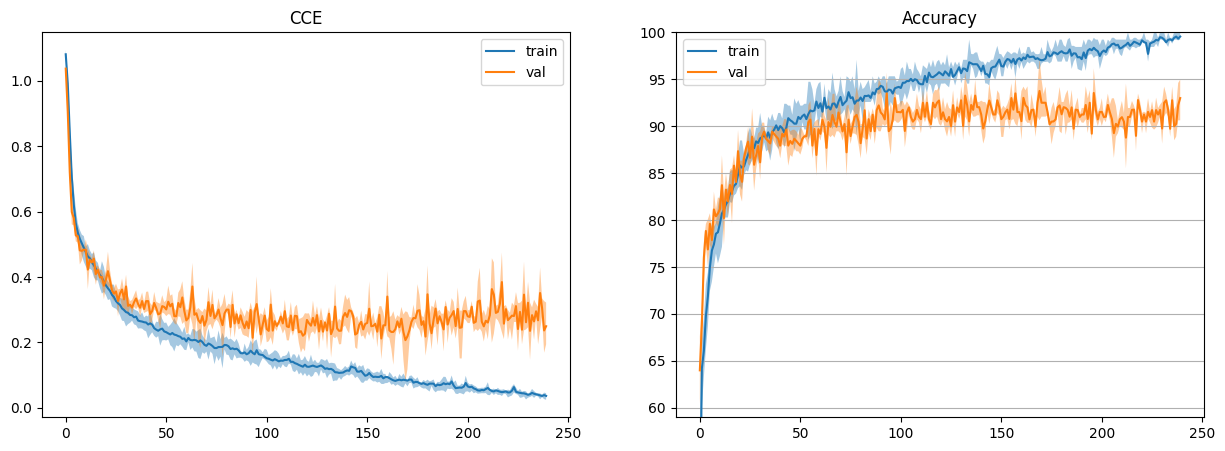

100%|██████████| 3000/3000 [00:01<00:00, 1679.30it/s]


Обучение закончено за 38.72810125350952 секунд


In [20]:
def train_classifier(
    model: nn.Module, learning_rate=5e-3, batch_size=128, epochs=EPOCHS, momentum=0.9
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    dataloader = create_dataloader(batch_size=batch_size)

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
    )


dataloader = train_classifier(model)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [21]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data
            # на GPU
            # inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [22]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)


compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

          17     0.9960    0.9980    0.9970       500
          70     0.9960    0.9980    0.9970       500
          35     1.0000    0.9960    0.9980       500

    accuracy                         0.9973      1500
   macro avg     0.9973    0.9973    0.9973      1500
weighted avg     0.9973    0.9973    0.9973      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9681    0.9100    0.9381       100
          70     0.8585    0.9100    0.8835       100
          35     0.9100    0.9100    0.9100       100

    accuracy                         0.9100       300
   macro avg     0.9122    0.9100    0.9105       300
weighted avg     0.9122    0.9100    0.9105       300



### Анализ результатов обучения модели
Как видно, лучше всего был предсказан класс с идентификатором 17, представляющий
собой замки. Вероятнее всего это связано с количеством общих уникальных черт объектов
на картинках: у замков их намного меньше по сравнению с, например, ребёнком,
который может быть разного возраста, расы и может быть одет по-разному.

На лицо так же переобучение: в обучающей выборке характеристики были почти идеальными,
а в тестовых данных для некоторых классов средними. Скорректируем параметры для устранения
этого феномена в надежде улучшить качество модели.

Подберём количество эпох.


6000it [00:03, 1597.00it/s]:00<?, ?it/s]


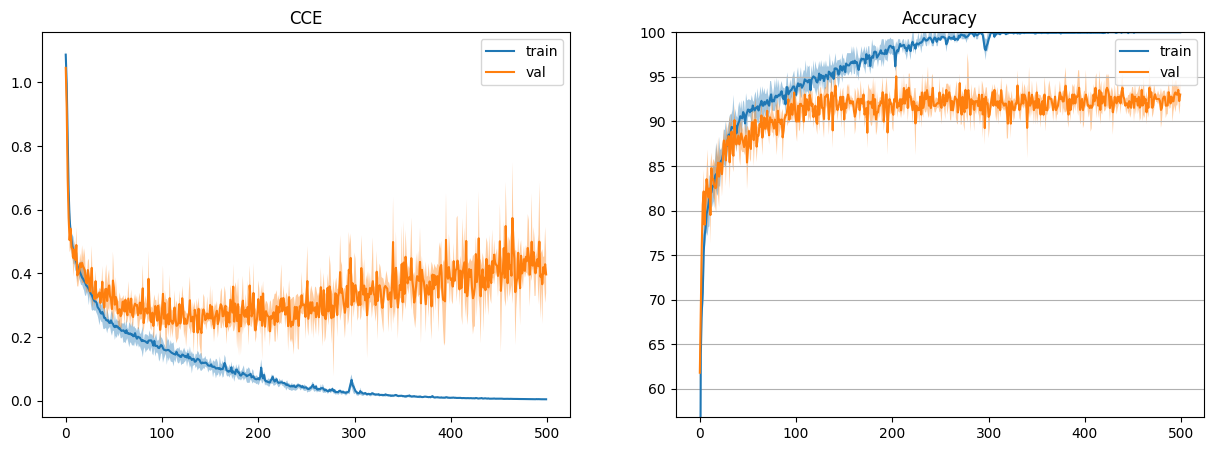

6000it [00:00, 9014.34it/s]             

Обучение закончено за 87.58345985412598 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9787    0.9200    0.9485       100
          70     0.8636    0.9500    0.9048       100
          35     0.9375    0.9000    0.9184       100

    accuracy                         0.9233       300
   macro avg     0.9266    0.9233    0.9239       300
weighted avg     0.9266    0.9233    0.9239       300



In [23]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=100)
compare_classification_reports(dataloader)


 56%|█████▌    | 1680/3000 [00:03<00:02, 440.18it/s]


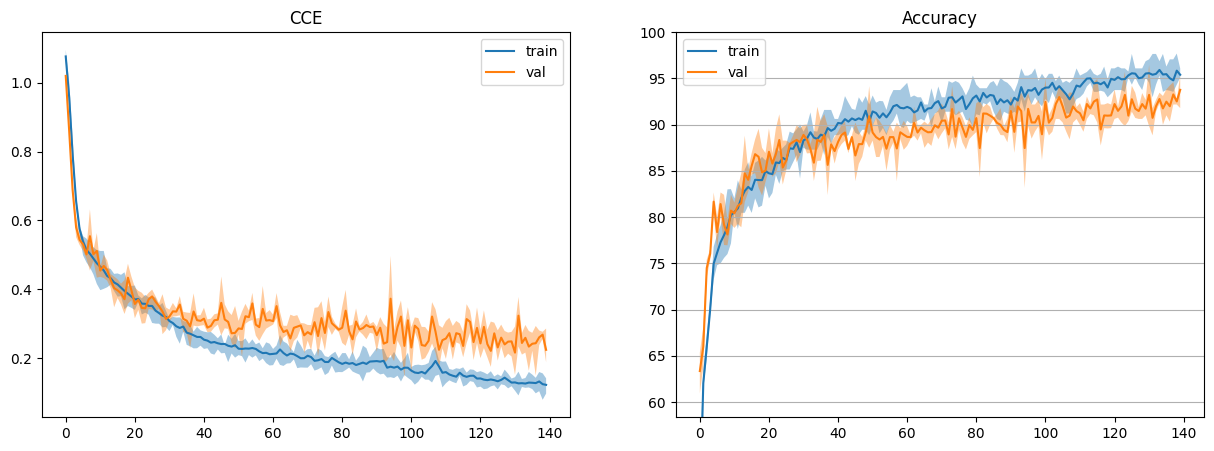


 60%|██████    | 1800/3000 [00:02<00:01, 735.34it/s][A


Обучение закончено за 23.41778326034546 секунд
train
              precision    recall  f1-score   support

          17     0.9720    0.9720    0.9720       500
          70     0.9524    0.9600    0.9562       500
          35     0.9798    0.9720    0.9759       500

    accuracy                         0.9680      1500
   macro avg     0.9681    0.9680    0.9680      1500
weighted avg     0.9681    0.9680    0.9680      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9592    0.9400    0.9495       100
          70     0.8725    0.8900    0.8812       100
          35     0.9100    0.9100    0.9100       100

    accuracy                         0.9133       300
   macro avg     0.9139    0.9133    0.9136       300
weighted avg     0.9139    0.9133    0.9136       300



In [24]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=150)
compare_classification_reports(dataloader)

 64%|██████▍   | 1920/3000 [00:03<00:01, 557.53it/s]


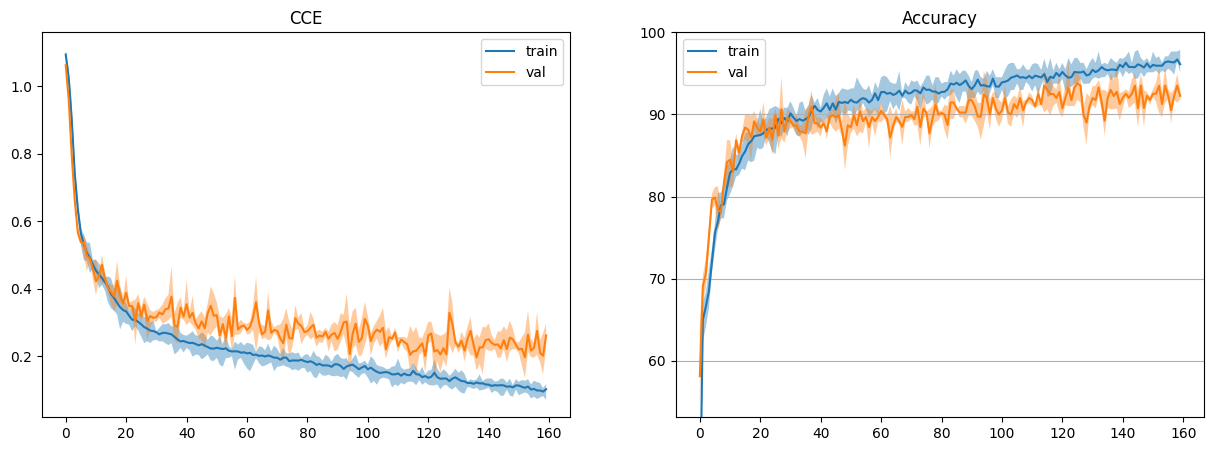

 64%|██████▍   | 1920/3000 [00:00<00:00, 4009.81it/s]

Обучение закончено за 29.90954327583313 секунд
train
              precision    recall  f1-score   support

          17     0.9721    0.9740    0.9730       500
          70     0.9520    0.9520    0.9520       500
          35     0.9679    0.9660    0.9670       500

    accuracy                         0.9640      1500
   macro avg     0.9640    0.9640    0.9640      1500
weighted avg     0.9640    0.9640    0.9640      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9588    0.9300    0.9442       100
          70     0.8750    0.9100    0.8922       100
          35     0.9293    0.9200    0.9246       100

    accuracy                         0.9200       300
   macro avg     0.9210    0.9200    0.9203       300
weighted avg     0.9210    0.9200    0.9203       300



In [25]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)

## Изменим конфигурацию модели свёрточной сети

### 1. Поменяем тактику пуллинга
Пуллинг с помощью шага свёртки stride.

Отдельные пуллинг слои уберём, оставим свёрточные со stride > kernel.


 24%|██▍       | 720/3000 [00:02<00:07, 297.57it/s]


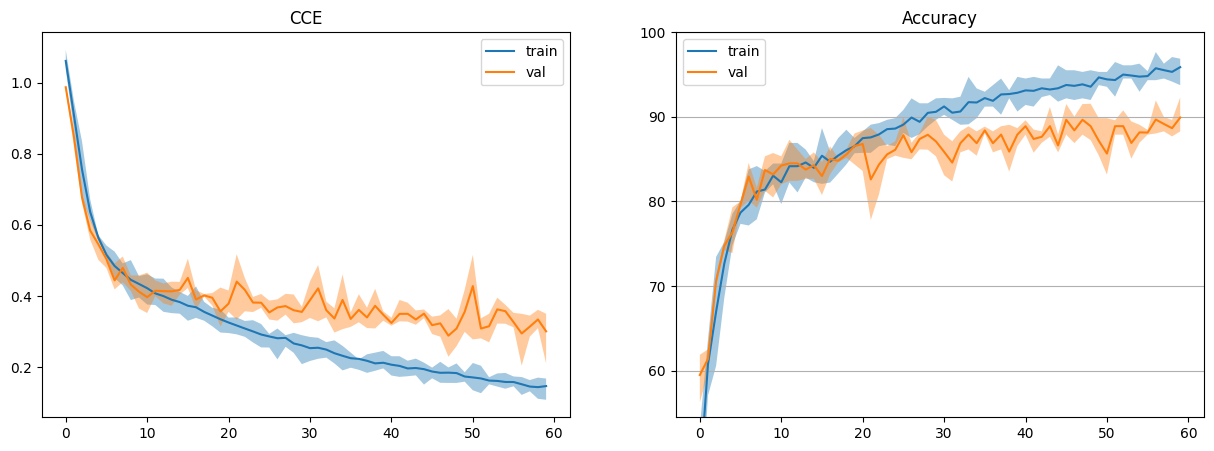


 30%|███       | 900/3000 [00:01<00:04, 491.76it/s]


Обучение закончено за 7.023476839065552 секунд
train
              precision    recall  f1-score   support

          17     0.9818    0.9720    0.9769       500
          70     0.9461    0.9820    0.9637       500
          35     0.9918    0.9640    0.9777       500

    accuracy                         0.9727      1500
   macro avg     0.9732    0.9727    0.9728      1500
weighted avg     0.9732    0.9727    0.9728      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9394    0.9300    0.9347       100
          70     0.8198    0.9100    0.8626       100
          35     0.9111    0.8200    0.8632       100

    accuracy                         0.8867       300
   macro avg     0.8901    0.8867    0.8868       300
weighted avg     0.8901    0.8867    0.8868       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4), padding=(2, 

In [26]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=4, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=75)
compare_classification_reports(dataloader)
print(model)

Добавим слой макс пуллинга.

Stride установим 2.

 64%|██████▍   | 1920/3000 [00:04<00:02, 470.13it/s]


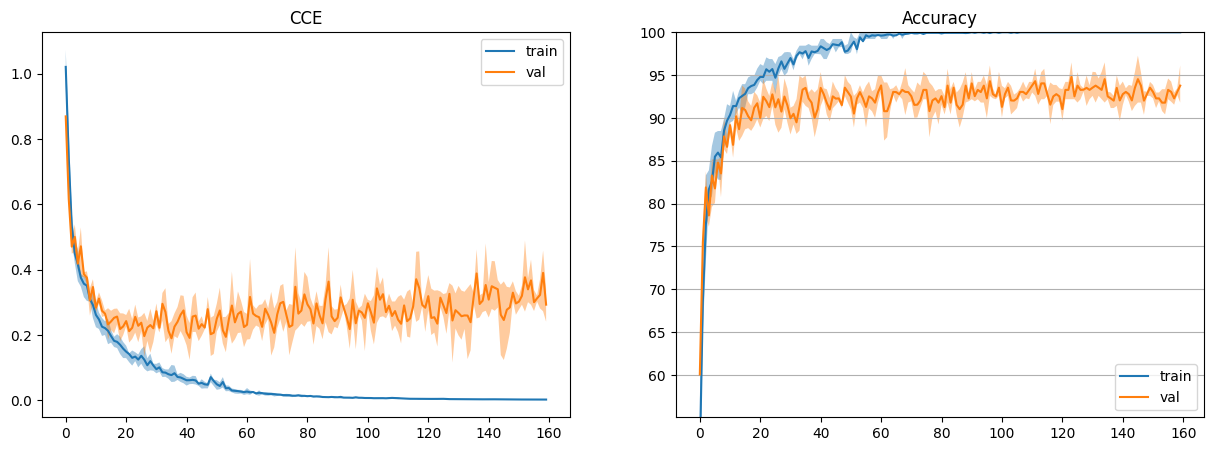

 64%|██████▍   | 1920/3000 [00:00<00:00, 3781.21it/s]

Обучение закончено за 31.758888721466064 секунд
train
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       500
          70     1.0000    1.0000    1.0000       500
          35     1.0000    1.0000    1.0000       500

    accuracy                         1.0000      1500
   macro avg     1.0000    1.0000    1.0000      1500
weighted avg     1.0000    1.0000    1.0000      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9500    0.9500    0.9500       100
          70     0.8774    0.9300    0.9029       100
          35     0.9574    0.9000    0.9278       100

    accuracy                         0.9267       300
   macro avg     0.9283    0.9267    0.9269       300
weighted avg     0.9283    0.9267    0.9269       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [27]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=2),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=160)
compare_classification_reports(dataloader)
print(model)


 67%|██████▋   | 240/360 [00:03<00:01, 71.40it/s]


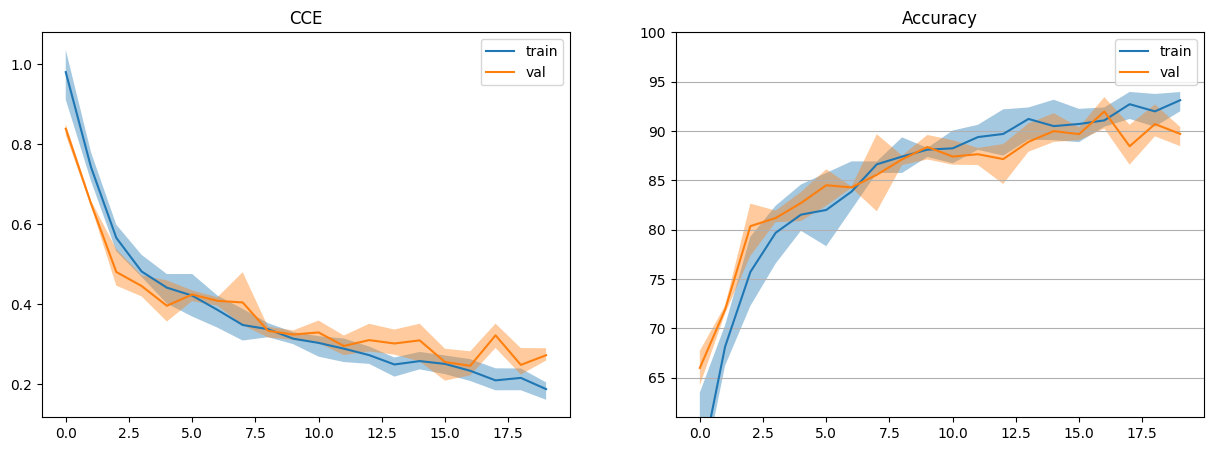


 12%|█▏        | 360/3000 [00:02<00:16, 156.39it/s][A


Обучение закончено за 3.3578102588653564 секунд
train
              precision    recall  f1-score   support

          17     0.9938    0.9660    0.9797       500
          70     0.9248    0.9840    0.9535       500
          35     0.9813    0.9460    0.9633       500

    accuracy                         0.9653      1500
   macro avg     0.9667    0.9653    0.9655      1500
weighted avg     0.9667    0.9653    0.9655      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9691    0.9400    0.9543       100
          70     0.8455    0.9300    0.8857       100
          35     0.9462    0.8800    0.9119       100

    accuracy                         0.9167       300
   macro avg     0.9203    0.9167    0.9173       300
weighted avg     0.9203    0.9167    0.9173       300



In [28]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=30)
compare_classification_reports(dataloader)

Поменяем слой макс пуллинга на усредняющий пуллинг


 40%|████      | 1200/3000 [00:03<00:05, 325.19it/s]


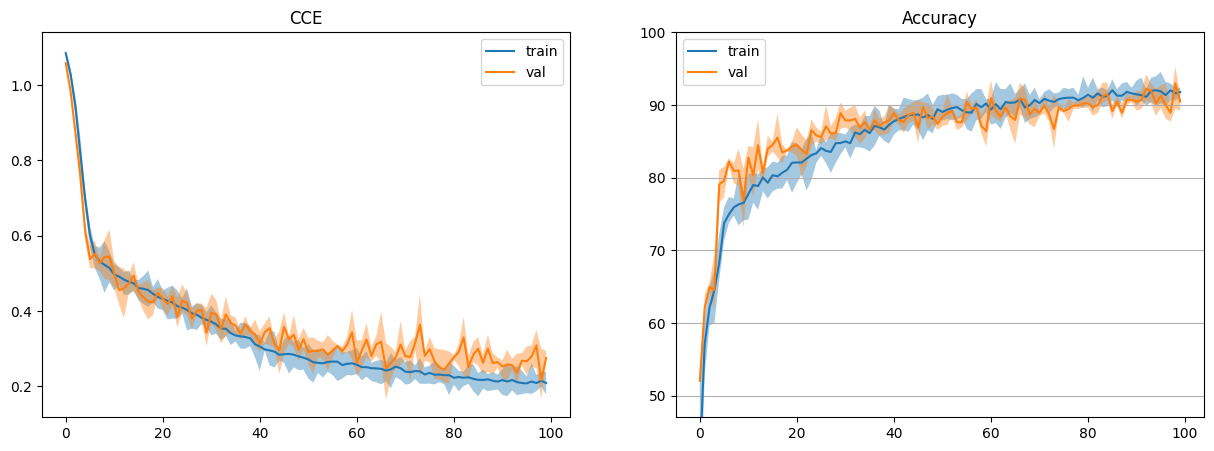

 40%|████      | 1200/3000 [00:00<00:00, 2699.78it/s]

Обучение закончено за 18.578816175460815 секунд
train
              precision    recall  f1-score   support

          17     0.9519    0.9500    0.9510       500
          70     0.9129    0.8800    0.8961       500
          35     0.9075    0.9420    0.9244       500

    accuracy                         0.9240      1500
   macro avg     0.9241    0.9240    0.9238      1500
weighted avg     0.9241    0.9240    0.9238      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9684    0.9200    0.9436       100
          70     0.8788    0.8700    0.8744       100
          35     0.8868    0.9400    0.9126       100

    accuracy                         0.9100       300
   macro avg     0.9113    0.9100    0.9102       300
weighted avg     0.9113    0.9100    0.9102       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2,

In [29]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=100)
compare_classification_reports(dataloader)
print(model)

 48%|████▊     | 1440/3000 [00:04<00:04, 342.94it/s]


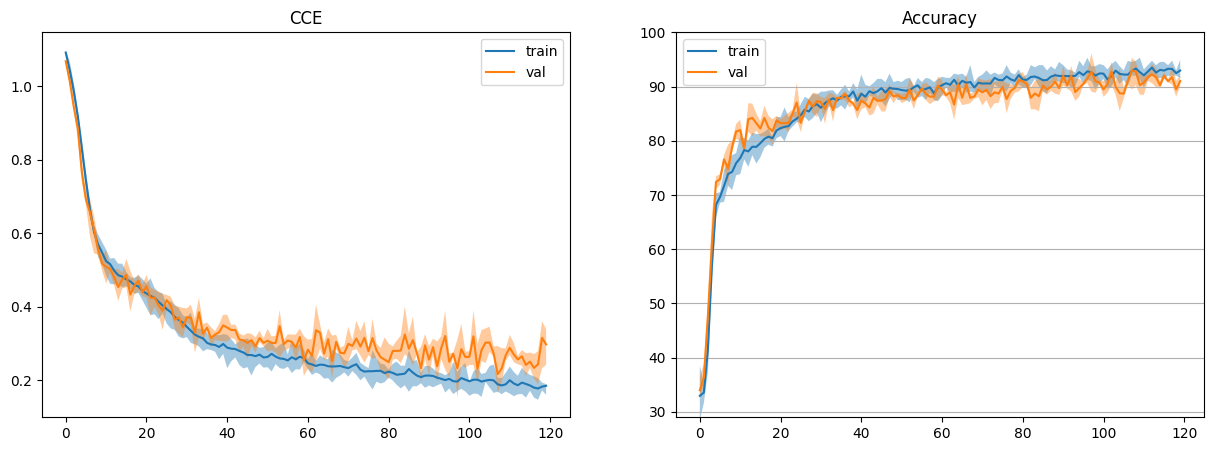

 48%|████▊     | 1440/3000 [00:00<00:00, 2942.31it/s]

Обучение закончено за 23.590613842010498 секунд
train
              precision    recall  f1-score   support

          17     0.9598    0.9540    0.9569       500
          70     0.9135    0.9080    0.9107       500
          35     0.9308    0.9420    0.9364       500

    accuracy                         0.9347      1500
   macro avg     0.9347    0.9347    0.9347      1500
weighted avg     0.9347    0.9347    0.9347      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9785    0.9100    0.9430       100
          70     0.8598    0.9200    0.8889       100
          35     0.9200    0.9200    0.9200       100

    accuracy                         0.9167       300
   macro avg     0.9194    0.9167    0.9173       300
weighted avg     0.9194    0.9167    0.9173       300



In [30]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=120)
compare_classification_reports(dataloader)


 56%|█████▌    | 1680/3000 [00:03<00:02, 466.27it/s]


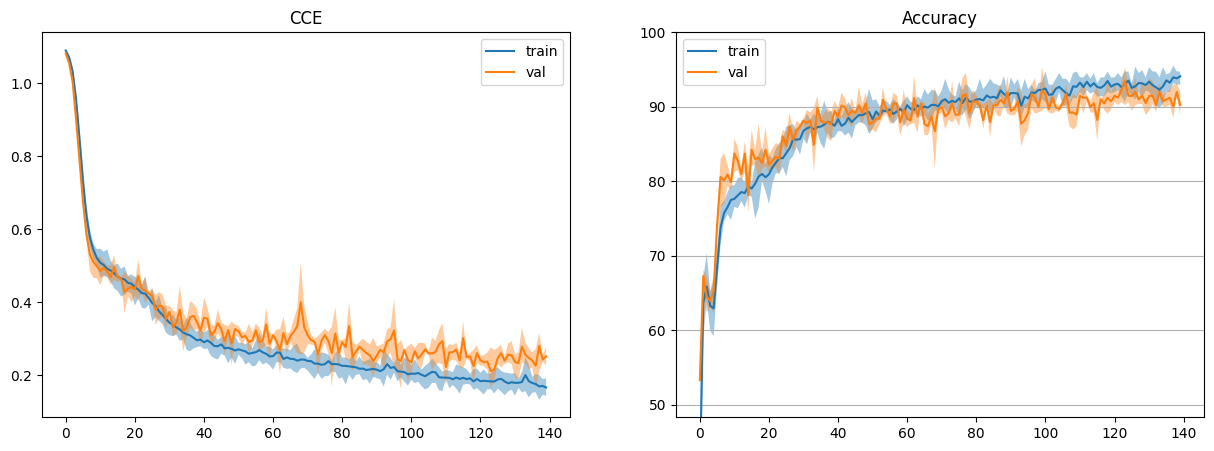

 56%|█████▌    | 1680/3000 [00:00<00:00, 3407.58it/s]

Обучение закончено за 26.428617477416992 секунд
train
              precision    recall  f1-score   support

          17     0.9578    0.9540    0.9559       500
          70     0.9000    0.9360    0.9176       500
          35     0.9564    0.9220    0.9389       500

    accuracy                         0.9373      1500
   macro avg     0.9381    0.9373    0.9375      1500
weighted avg     0.9381    0.9373    0.9375      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9785    0.9100    0.9430       100
          70     0.8519    0.9200    0.8846       100
          35     0.9192    0.9100    0.9146       100

    accuracy                         0.9133       300
   macro avg     0.9165    0.9133    0.9141       300
weighted avg     0.9165    0.9133    0.9141       300



In [31]:
model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=140)
compare_classification_reports(dataloader)

### Поменяем количество свёрточных слоёв
В качестве базовой выберем конфигурацию модели с макс пуллингом, так как она проявила себя лучше всего.

Поэкспериментируем над количеством свёрточных слоёв (параметр hidden_size в конструкторе).


 16%|█▌        | 480/3000 [00:07<00:39, 64.08it/s]


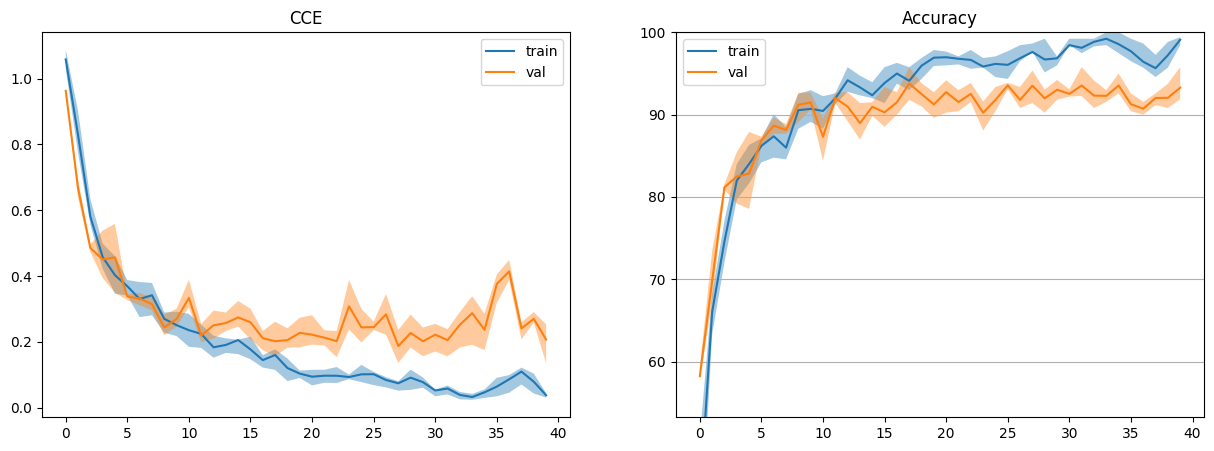

 16%|█▌        | 480/3000 [00:00<00:02, 972.07it/s]

Обучение закончено за 14.426873922348022 секунд
train
              precision    recall  f1-score   support

          17     0.9960    0.9920    0.9940       500
          70     0.9901    0.9980    0.9940       500
          35     1.0000    0.9960    0.9980       500

    accuracy                         0.9953      1500
   macro avg     0.9954    0.9953    0.9953      1500
weighted avg     0.9954    0.9953    0.9953      1500

-----------------------------------------------------
test


              precision    recall  f1-score   support

          17     0.9796    0.9600    0.9697       100
          70     0.8679    0.9200    0.8932       100
          35     0.9375    0.9000    0.9184       100

    accuracy                         0.9267       300
   macro avg     0.9283    0.9267    0.9271       300
weighted avg     0.9283    0.9267    0.9271       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=3, padding=2, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim

In [38]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=3, padding=2),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=2*HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=40)
compare_classification_reports(dataloader)
print(model)



 80%|████████  | 240/300 [00:07<00:01, 33.40it/s]


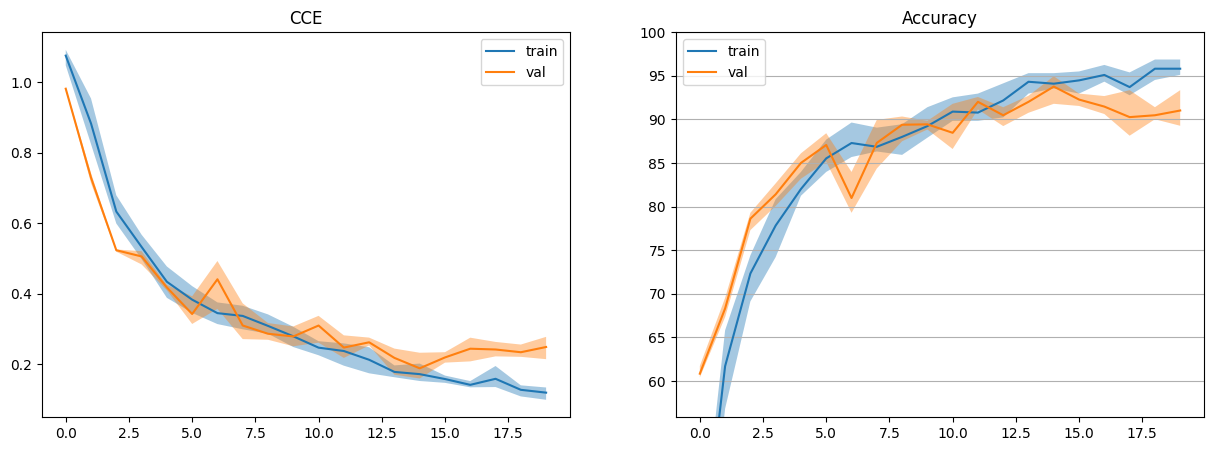



  8%|▊         | 241/3000 [00:00<00:07, 346.31it/s]

  8%|▊         | 246/3000 [00:00<00:09, 279.87it/s]

  8%|▊         | 251/3000 [00:00<00:12, 227.46it/s]

  9%|▊         | 256/3000 [00:01<00:15, 173.92it/s]

  9%|▊         | 261/3000 [00:01<00:19, 141.78it/s]

  9%|▉         | 266/3000 [00:01<00:26, 102.73it/s]

  9%|▉         | 271/3000 [00:01<00:31, 86.07it/s] 

  9%|▉         | 276/3000 [00:01<00:35, 76.29it/s]

  9%|▉         | 281/3000 [00:01<00:44, 61.31it/s]

 10%|▉         | 286/3000 [00:01<00:48, 55.86it/s]

 10%|▉         | 291/3000 [00:02<00:55, 48.59it/s]

 10%|█         | 300/3000 [00:02<00:20, 129.28it/s][A


Обучение закончено за 7.18271803855896 секунд
train
              precision    recall  f1-score   support

          17     0.9959    0.9720    0.9838       500
          70     0.9745    0.9940    0.9842       500
          35     0.9900    0.9940    0.9920       500

    accuracy                         0.9867      1500
   macro avg     0.9868    0.9867    0.9867      1500
weighted avg     0.9868    0.9867    0.9867      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9794    0.9500    0.9645       100
          70     0.8649    0.9600    0.9100       100
          35     0.9565    0.8800    0.9167       100

    accuracy                         0.9300       300
   macro avg     0.9336    0.9300    0.9304       300
weighted avg     0.9336    0.9300    0.9304       300



In [43]:
model = Cifar100_CNN(hidden_size=2*HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=25)
compare_classification_reports(dataloader)

### Поменяем ядро свёртки
Поменяем с 5 до 7 на первом свёрточном слое.



 67%|██████▋   | 240/360 [00:03<00:01, 69.41it/s]


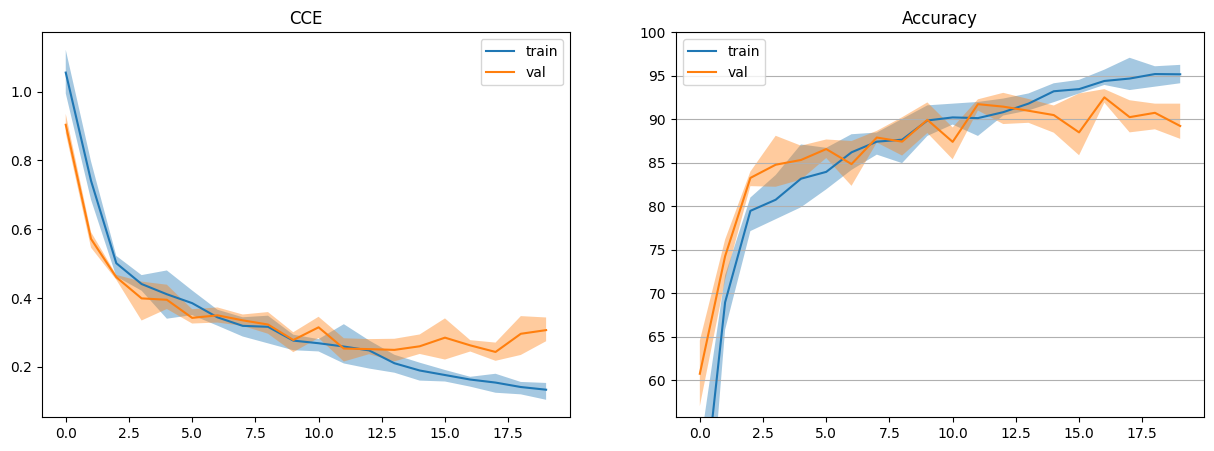



  8%|▊         | 241/3000 [00:00<00:06, 453.92it/s]

  8%|▊         | 248/3000 [00:00<00:07, 366.61it/s]

  8%|▊         | 254/3000 [00:00<00:09, 287.97it/s]

  9%|▊         | 261/3000 [00:00<00:11, 229.04it/s]

  9%|▉         | 267/3000 [00:00<00:14, 183.21it/s]

  9%|▉         | 275/3000 [00:01<00:17, 155.17it/s]

  9%|▉         | 282/3000 [00:01<00:20, 130.51it/s]

 10%|▉         | 289/3000 [00:01<00:25, 105.17it/s]

 10%|▉         | 298/3000 [00:01<00:27, 98.32it/s] 

 10%|█         | 304/3000 [00:01<00:31, 86.41it/s]

 10%|█         | 313/3000 [00:01<00:31, 84.57it/s]

 11%|█         | 322/3000 [00:01<00:31, 84.22it/s]

 11%|█         | 330/3000 [00:01<00:33, 80.71it/s]

 11%|█▏        | 339/3000 [00:01<00:31, 83.24it/s]

 12%|█▏        | 349/3000 [00:02<00:31, 84.62it/s]

 12%|█▏        | 360/3000 [00:02<00:16, 164.04it/s][A


Обучение закончено за 3.4541749954223633 секунд
train
              precision    recall  f1-score   support

          17     0.9919    0.9800    0.9859       500
          70     0.9800    0.9800    0.9800       500
          35     0.9881    1.0000    0.9940       500

    accuracy                         0.9867      1500
   macro avg     0.9867    0.9867    0.9867      1500
weighted avg     0.9867    0.9867    0.9867      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9592    0.9400    0.9495       100
          70     0.9184    0.9000    0.9091       100
          35     0.9038    0.9400    0.9216       100

    accuracy                         0.9267       300
   macro avg     0.9271    0.9267    0.9267       300
weighted avg     0.9271    0.9267    0.9267       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(7, 7), stride=(3, 3), padding=(2,

In [48]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=7, stride=3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=2, padding=3),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=30)
compare_classification_reports(dataloader)
print(model)

### Поменяем шаг свёртки
Поменяем stride с 3 до 2










 67%|██████▋   | 240/360 [00:04<00:02, 59.55it/s]


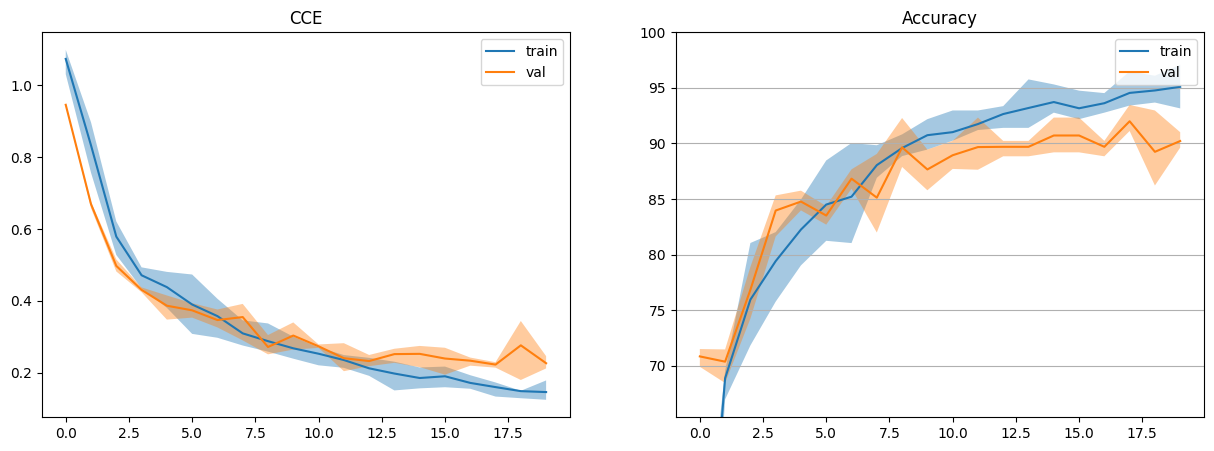










  8%|▊         | 241/3000 [00:00<00:06, 459.80it/s]








  8%|▊         | 248/3000 [00:00<00:07, 375.37it/s]








  8%|▊         | 254/3000 [00:00<00:09, 292.96it/s]








  9%|▊         | 261/3000 [00:00<00:11, 231.43it/s]








  9%|▉         | 267/3000 [00:00<00:14, 184.15it/s]








  9%|▉         | 274/3000 [00:01<00:17, 152.51it/s]








  9%|▉         | 280/3000 [00:01<00:21, 126.44it/s]








 10%|▉         | 286/3000 [00:01<00:25, 107.61it/s]








 10%|▉         | 291/3000 [00:01<00:29, 90.69it/s] 








 10%|▉         | 299/3000 [00:01<00:31, 84.79it/s]








 10%|█         | 305/3000 [00:01<00:35, 76.12it/s]








 10%|█         | 313/3000 [00:01<00:36, 73.28it/s]








 11%|█         | 322/3000 [00:01<00:35, 75.99it/s]








 11%|█         | 329/3000 [00:01<00:36, 73.02it/s]








 11%|█         | 337/3000 [00:02<00:39, 67.48it/s]








 11%|█▏        | 344/3000 [00:02<00:40, 65.84it/s]








 12%|█▏        | 349/3000 [00:02<00:45

Обучение закончено за 4.026482105255127 секунд
train
              precision    recall  f1-score   support

          17     0.9939    0.9760    0.9849       500
          70     0.9796    0.9600    0.9697       500
          35     0.9576    0.9940    0.9755       500

    accuracy                         0.9767      1500
   macro avg     0.9770    0.9767    0.9767      1500
weighted avg     0.9770    0.9767    0.9767      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     0.9691    0.9400    0.9543       100
          70     0.8980    0.8800    0.8889       100
          35     0.8857    0.9300    0.9073       100

    accuracy                         0.9167       300
   macro avg     0.9176    0.9167    0.9168       300
weighted avg     0.9176    0.9167    0.9168       300

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 

In [60]:
class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE, classes=100):
        super(Cifar100_CNN, self).__init__()
        self.seq = nn.Sequential(
            Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
            nn.Conv2d(3, hidden_size, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2, padding=1),
            nn.Conv2d(hidden_size, hidden_size * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(hidden_size * 8, classes),
        )

    def forward(self, input):
        return self.seq(input)


model = Cifar100_CNN(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
dataloader = train_classifier(model, epochs=30)
compare_classification_reports(dataloader)
print(model)

## Экспорт модели

In [61]:
model_path = Path("models")
model_filename = "cifar_cnn.pt"

model_path.mkdir(exist_ok=True)

model_file_path = model_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

Cifar100_CNN(
  (seq): Sequential(
    (0): Normalize()
    (1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=5, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [62]:
# входной тензор для модели
onnx_model_filename = "cifar100_cnn.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(
    model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path/onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)